In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# author: Ji Liu email: ji.liu@anl.gov

import itertools, numpy
# import circuit_cutter
# import mlrecon_methods as ml
import numpy as np

import qiskit
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile

from qiskit.transpiler import PassManager

from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble

from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel

from utils.utils import filter_results, dict_to_list, H_distance, total_counts
from vqe_utils import read_from_file, MeasureCircuit, find_commute_groups, evaluation
import mthree

In [3]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='chm185')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_montreal') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_kolkata') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_mumbai') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQBackend('ibmq_guadalupe') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-ornl', grou

In [5]:
device = provider.get_backend('ibmq_toronto')

In [6]:
device

<IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-ornl', group='ornl', project='chm185')>

In [7]:
orign_qc = QuantumCircuit.from_qasm_file("qasm/vqe_LiH.qasm")

In [8]:
orign_qc.draw()

┌───┐      ┌───────────────┐   ┌────────────────┐                 »
q_0: ──────┤ X ├──────┤ Ry(-0.003534) ├─■─┤ Ry(-0.0036834) ├─────────────────»
           ├───┤      ├───────────────┤ │ └────────────────┘┌───────────────┐»
q_1: ──────┤ X ├──────┤ Ry(-0.015869) ├─■─────────■─────────┤ Ry(-0.015751) ├»
     ┌─────┴───┴─────┐└───────────────┘           │         └───────────────┘»
q_2: ┤ Ry(0.0038243) ├────────────────────────────■─────────────────■────────»
     ├───────────────┤                                              │        »
q_3: ┤ Ry(-0.019851) ├──────────────────────────────────────────────■────────»
     └───────────────┘                                                       »
«                      
«q_0: ─────────────────
«                      
«q_1: ─────────────────
«     ┌───────────────┐
«q_2: ┤ Ry(0.0036205) ├
«     └┬──────────────┤
«q_3: ─┤ Ry(0.019873) ├
«      └──────────────┘

In [9]:
pauli_list = read_from_file('LiH_hamiltonian.txt')

In [10]:
pauli_commute = find_commute_groups(pauli_list)

In [11]:
pauli_commute

[[('YYYY', (0.030846096963273145+0j)),
  ('IIYY', (0.0007427996394965804+0j)),
  ('YYII', (0.0007427996394965839+0j)),
  ('IIII', (-0.20316606150559144+0j))],
 [('ZZYY', (-0.002737250612332958+0j)),
  ('IZYY', (-0.032395297319862765+0j)),
  ('ZIYY', (0.034389748140479+0j)),
  ('ZZII', (-0.21188984297009175+0j)),
  ('IZII', (0.09275994933497334+0j)),
  ('ZIII', (-0.3652586902160353+0j))],
 [('YYZZ', (-0.002737250612332958+0j)),
  ('YYIZ', (0.032395297319862765+0j)),
  ('YYZI', (-0.034389748140479+0j)),
  ('IIZZ', (-0.21188984297009167+0j)),
  ('IIIZ', (-0.09275994933497325+0j)),
  ('IIZI', (0.3652586902160354+0j))],
 [('XZYY', (-0.007859003265897889+0j)),
  ('XIYY', (0.007859003265897889+0j)),
  ('XZII', (-0.019389408583701813+0j)),
  ('XIII', (0.019389408583701813+0j))],
 [('YYXZ', (0.007859003265897889+0j)),
  ('YYXI', (0.007859003265897889+0j)),
  ('IIXZ', (0.019389408583701813+0j)),
  ('IIXI', (0.019389408583701813+0j))],
 [('YYZX', (-0.0084991584698088+0j)),
  ('YYIX', (0.008499158

In [12]:
len(pauli_commute)

25

In [13]:
pauli_commute

[[('YYYY', (0.030846096963273145+0j)),
  ('IIYY', (0.0007427996394965804+0j)),
  ('YYII', (0.0007427996394965839+0j)),
  ('IIII', (-0.20316606150559144+0j))],
 [('ZZYY', (-0.002737250612332958+0j)),
  ('IZYY', (-0.032395297319862765+0j)),
  ('ZIYY', (0.034389748140479+0j)),
  ('ZZII', (-0.21188984297009175+0j)),
  ('IZII', (0.09275994933497334+0j)),
  ('ZIII', (-0.3652586902160353+0j))],
 [('YYZZ', (-0.002737250612332958+0j)),
  ('YYIZ', (0.032395297319862765+0j)),
  ('YYZI', (-0.034389748140479+0j)),
  ('IIZZ', (-0.21188984297009167+0j)),
  ('IIIZ', (-0.09275994933497325+0j)),
  ('IIZI', (0.3652586902160354+0j))],
 [('XZYY', (-0.007859003265897889+0j)),
  ('XIYY', (0.007859003265897889+0j)),
  ('XZII', (-0.019389408583701813+0j)),
  ('XIII', (0.019389408583701813+0j))],
 [('YYXZ', (0.007859003265897889+0j)),
  ('YYXI', (0.007859003265897889+0j)),
  ('IIXZ', (0.019389408583701813+0j)),
  ('IIXI', (0.019389408583701813+0j))],
 [('YYZX', (-0.0084991584698088+0j)),
  ('YYIX', (0.008499158

In [14]:
#generate individual measurment circuits that changes the basis
meas_qcs = []
for i in range(0, len(pauli_commute)):
    temp_qc = MeasureCircuit(pauli_commute[i], 4, 4)
    meas_qcs.append(temp_qc)

YYYY
YYZZ
ZZYY
YYZX
ZXYY
XZYY
YYXZ
XXYY
YYXX
XZZZ
ZZXZ
XZZX
ZXXZ
XXZZ
ZZXX
XZXZ
ZXZX
XXZX
ZXXX
XZXX
XXXZ
ZZZX
ZXZZ
XXXX
ZZZZ


In [15]:
len(meas_qcs)

25

In [16]:
qc_list = []
for qc in meas_qcs:
    temp_qc = orign_qc + qc
    temp_qc.measure_all()
    qc_list.append(temp_qc)

/var/folders/s4/3cvgkkn17hg628pzrzzjnhww0000gn/T/ipykernel_69685/856425490.py:3: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  temp_qc = orign_qc + qc


In [17]:
qc_list[-1].draw()

┌───┐      ┌───────────────┐   ┌────────────────┐»
   q_0: ──────┤ X ├──────┤ Ry(-0.003534) ├─■─┤ Ry(-0.0036834) ├»
              ├───┤      ├───────────────┤ │ └────────────────┘»
   q_1: ──────┤ X ├──────┤ Ry(-0.015869) ├─■─────────■─────────»
        ┌─────┴───┴─────┐└───────────────┘           │         »
   q_2: ┤ Ry(0.0038243) ├────────────────────────────■─────────»
        ├───────────────┤                                      »
   q_3: ┤ Ry(-0.019851) ├──────────────────────────────────────»
        └───────────────┘                                      »
meas_0: ═══════════════════════════════════════════════════════»
                                                               »
meas_1: ═══════════════════════════════════════════════════════»
                                                               »
meas_2: ═══════════════════════════════════════════════════════»
                                                               »
meas_3: ═══════════════════════════════════════════════════════»
                                                               »
«                                           ░ ┌─┐         
«   q_0: ───────────────────────────────────░─┤M├─────────
«        ┌───────────────┐                  ░ └╥┘┌─┐      
«   q_1: ┤ Ry(-0.015751) ├──────────────────░──╫─┤M├──────
«        └───────────────┘┌───────────────┐ ░  ║ └╥┘┌─┐   
«   q_2: ────────■────────┤ Ry(0.0036205) ├─░──╫──╫─┤M├───
«                │        └┬──────────────┤ ░  ║  ║ └╥┘┌─┐
«   q_3: ────────■─────────┤ Ry(0.019873) ├─░──╫──╫──╫─┤M├
«                          └──────────────┘ ░  ║  ║  ║ └╥┘
«meas_0: ══════════════════════════════════════╩══╬══╬══╬═
«                                                 ║  ║  ║ 
«meas_1: ═════════════════════════════════════════╩══╬══╬═
«                                                    ║  ║ 
«meas_2: ════════════════════════════════════════════╩══╬═
«                                                       ║ 
«meas_3: ═══════════════════════════════════════════════╩═
«

In [18]:
num_qcs = len(qc_list)
num_qcs

25

In [19]:
max_shots = device.configuration().to_dict()['max_shots']
max_shots

32000

In [21]:
job_sim = execute(qc_list, backend = device, initial_layout = [16,14,11,8], optimization_level = 3, shots = max_shots, seed_transpiler = 0)
print(job_sim.job_id())

63777de818d74896e6f75522


In [23]:
job = device.retrieve_job(job_id='63777de818d74896e6f75522')

In [24]:
result = job.result()

In [25]:
result.get_counts()

[{'0000': 1891,
  '0001': 1955,
  '0010': 1854,
  '0011': 1883,
  '0100': 1893,
  '0101': 1960,
  '0110': 1737,
  '0111': 1757,
  '1000': 2270,
  '1001': 2197,
  '1010': 2023,
  '1011': 1960,
  '1100': 2216,
  '1101': 2064,
  '1110': 2220,
  '1111': 2120},
 {'0000': 7216,
  '0001': 6962,
  '0010': 8792,
  '0011': 8180,
  '0100': 131,
  '0101': 104,
  '0110': 106,
  '0111': 83,
  '1000': 91,
  '1001': 75,
  '1010': 119,
  '1011': 126,
  '1100': 1,
  '1101': 5,
  '1110': 6,
  '1111': 3},
 {'0000': 5,
  '0001': 252,
  '0010': 226,
  '0011': 7317,
  '0100': 15,
  '0101': 241,
  '0110': 226,
  '0111': 6842,
  '1000': 15,
  '1001': 311,
  '1010': 275,
  '1011': 7928,
  '1100': 17,
  '1101': 285,
  '1110': 242,
  '1111': 7803},
 {'0000': 4164,
  '0001': 4039,
  '0010': 4114,
  '0011': 3909,
  '0100': 56,
  '0101': 42,
  '0110': 36,
  '0111': 38,
  '1000': 4019,
  '1001': 3950,
  '1010': 3813,
  '1011': 3616,
  '1100': 58,
  '1101': 53,
  '1110': 49,
  '1111': 44},
 {'0000': 138,
  '0001': 391

In [31]:
import json
with open('LiH_toronto_orign.json', 'w') as f:
    json.dump(result.get_counts(), f)

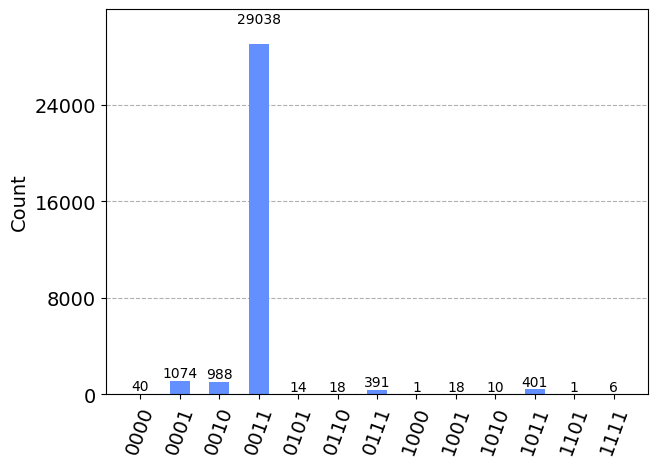

In [26]:
plot_histogram(result.get_counts()[-1])

In [27]:
len(result.get_counts())

25

In [28]:
len(pauli_commute)

25

In [29]:
final_expect_val = 0
for i in range(0, len(pauli_commute)):
    group = pauli_commute[i]
    for Pauli_tuple in group:
        coeff = Pauli_tuple[1]
        final_expect_val += coeff * evaluation(result.get_counts()[i], shots = max_shots, Pauli = Pauli_tuple[0])  

In [30]:
final_expect_val

(-1.0194585815515294+0j)